## Setup

In [1]:
!nvidia-smi

Fri Dec 23 20:47:14 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    26W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import matplotlib.pyplot as plt # for plotting
import seaborn as sns
import numpy as np # for transformation

import torch # PyTorch package
import torchvision # load datasets
import torchvision.transforms as transforms # transform data
import torch.nn as nn # basic building block for neural neteorks
import torch.nn.functional as F # import convolution functions like Relu
import torch.optim as optim # optimzer
from torch.autograd import Variable 

#!pip install pandas==1.3.0 #1.3.0
import pandas as pd

import glob
!pip3 install pickle5
import pickle5 as pickle
import os

from torch.utils.data import Dataset, DataLoader, random_split, Subset, RandomSampler
from sklearn.metrics import f1_score, precision_score, recall_score
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import auc, confusion_matrix

import statsmodels 
import statsmodels.sandbox.stats.runs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 132 kB 11.6 MB/s 
  Created wheel for pickle5: filename=pickle5-0.0.11-cp38-cp38-linux_x86_64.whl size=236275 sha256=51622e349e2d45de97e154df771a7e6a10df55681a27493bb9d45939f5c291f0
  Stored in directory: /root/.cache/pip/wheels/25/d4/61/dbd8edd1a0d656be7b4267c85db3b61951eb60016a0154a122
Successfully built pickle5


### Five Key Steps
#### 1. Load and normalize the train and test data 
#### 2.Define the Convolutional Neural Network (CNN)
#### 3. Define the loss function and optimizer
#### 4. Train the model on the train data
#### 5. Test the model on the test data

In [3]:
#Mount Drive to get data
from google.colab import drive 
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
#set the device to cuda:0 
if torch.cuda.is_available():  
  device = "cuda:0" 
else:  
  device = "cpu"  

## Dataset

In [5]:
#Load In the Dataset
class EEGDataset(Dataset):

  def __init__(self, data_path, chunk_size=1000):
    """
        Args:
            data_path (string): Directory with the EEG training data. Filenames in this dir must begin with "PD" or "Control" to assign labels correctly. Must be in .csv files. 
            chunk_size (int): Number of datapoints from EEG time series to be included in a single non-overlapping epoch. Note that UNM data was collected at 500Hz.
    """
    #create containers for the data and labels respectively
    self.df_list = []
    self.label_list = []

    #create a list of datafields to keep. The electrodes given here are those in common to both the UI and UNM datasets.
    self.common_electrodes = ['time', 'Fp1', 'Fz', 'F3', 'F7', 'FC5', 'FC1', 'C3', 'T7', 'TP9', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'TP10', 'CP6', 'CP2', 'Cz', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8', 'Fp2', 'AF7', 'AF3', 'AFz', 'F1', 'F5', 'FT7', 'FC3', 'FCz', 'C1', 'C5', 'TP7', 'CP3', 'P1', 'P5', 'PO7', 'POz', 'PO8', 'P6', 'P2', 'CP4', 'TP8', 'C6', 'C2', 'FC4', 'FT8', 'F6', 'F2', 'AF4', 'AF8']
    if data_path[-4:] != '.csv':

      #create the datapaths
      self.data_path = data_path  
      self.data_list = glob.glob(self.data_path + "*.csv")

      

      self.files = glob.glob(self.data_path+ '*.csv')

    else:
      self.files = [data_path]

    for file in self.files:
      
      if os.path.isfile(file):
        csv = pd.read_csv(file,sep=',', index_col=[0]) #load in single session as a csv
        csv.drop(index=0, inplace=True, axis=0) #drop first row because it's usually noisy
        csv = csv[self.common_electrodes]             #select the subset of electrodes defined by self.common_electrodes
        csv.drop('time', inplace=True, axis=1) #drop time so it is not considered as a variable

        #csv is then segmented into epochs. Each epochs is added as a df to the list of data with a corresponding list of labels (at this point the whole filename is given as the label).
        for chunk in range(1,csv.shape[0]//chunk_size +1):
            start = (chunk-1)*chunk_size
            stop = chunk*chunk_size
            self.df_list.append(csv.iloc[start:stop])
            self.label_list.append(file)

    print('there are this many items in the list of data ' ,len(self.df_list))  
    print('there are this many items in the list of labels ' , len(self.label_list))

    #define the labels as vectors to match training
    self.class_map = {"CTL" : [0, 1], "PD": [1, 0]} 
    
    #Normalize each channel of each epoch to a mean of 0 and std of 1.
    self.all_data = self.df_list[0]
    
    self.normalized_df_list = []
    
    #iterate through each epoch
    for df_index in range(0,len(self.df_list)):
      
      temp_df = self.df_list[df_index]
      mean_by_channel = []
      std_by_channel = []
      
      #determine normalization parameters by column (i.e. for each channel)
      for column in temp_df:
        mean_by_channel.append(temp_df[column].mean())
        std_by_channel.append(temp_df[column].std())

      #apply normalization
      temp_df = temp_df.sub(mean_by_channel, axis='columns')
      temp_df = temp_df.div(std_by_channel, axis='columns')
      self.normalized_df_list.append(temp_df)

    assert (len(std_by_channel)== len(mean_by_channel)), 'length of mean normalization and std normalization are not same length'
    print('The length of the lists of channels means and stds is ', len(mean_by_channel))
    assert ((self.normalized_df_list[0].shape)==(self.df_list[0].shape) and (len(self.normalized_df_list)==len(self.df_list))), 'Normalization changed the shape of the df_list'
      

  #this is a required function that tells you how many data points you have in the dataset
  def __len__(self):
      return len(self.normalized_df_list) 

  #this is a required function that allows you to obtain a single data point according to its index
  def __getitem__(self, idx):
    
    #each dataframe represents one block id
    eeg_dataframe = self.normalized_df_list[idx]
    
    #determine whether that subject is control or PD
    filename = self.label_list[idx].split('/')[-1]
    
    # this is the string containing the filename. index first 2 chars to see if PD.
    if filename[0:2]=='PD':
      PD_label = 'PD'
    # then see if its control
    elif filename[0:3]=='CTL':
      PD_label = 'CTL'
    # if neither, throw an error
    else:
      print(filename[0:2])
      print(filename[0:7])
      assert False, 'there is a problem finding the label'

    #convert label to tensor using class map
    PD_label = torch.tensor(self.class_map[PD_label], dtype=torch.long)
    
    #reformat the eeg data
    eeg_tensor = torch.tensor(eeg_dataframe[0:chunk_size].values) #you can artificially shorten epochs here
    eeg_tensor = torch.permute(eeg_tensor,(1, 0))
    
    return eeg_tensor.float(), PD_label.float(), filename


## Define the Neural Network

In [6]:
class PDNet(nn.Module):

    def __init__(self,chunk_size=2500):
        super(PDNet, self).__init__()
        self.chunk_size = chunk_size

        self.conv1 = nn.Conv1d(in_channels=60, out_channels=21, kernel_size=20,stride=1)
        self.norm1 = nn.BatchNorm1d(num_features=21)
        self.maxpool1 = nn.MaxPool1d(kernel_size=4,stride=4)

        self.conv2 = nn.Conv1d(in_channels=21, out_channels=42, kernel_size=10,stride=1)
        self.norm2 = nn.BatchNorm1d(num_features=42)
        self.maxpool2 = nn.MaxPool1d(kernel_size=4,stride=4)

        self.conv3 = nn.Conv1d(in_channels=42, out_channels=42, kernel_size=10,stride=1)
        self.norm3 = nn.BatchNorm1d(num_features=42)
        self.maxpool3 = nn.MaxPool1d(kernel_size=4,stride=4)

        self.conv4 = nn.Conv1d(in_channels=42, out_channels=64, kernel_size=5,stride=1)
        self.norm4 = nn.BatchNorm1d(num_features=64)
        self.maxpool4 = nn.MaxPool1d(kernel_size=4,stride=4)

        
        self.relu = nn.LeakyReLU(0.1)

        
        self.fc1 = nn.Linear(in_features=448,out_features=256)#in_features=4*(self.chunk_size-8)
        self.dropout1 = nn.Dropout(p=0.5)

        self.fc2 = nn.Linear(in_features=256, out_features=64)
        self.dropout2 = nn.Dropout(p=0.5)

        self.fc3 = nn.Linear(in_features=64, out_features=16)
        self.fc4 = nn.Linear(in_features=16, out_features=2)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):

        x = self.relu(self.maxpool1(self.norm1(self.conv1(x))))

        x = self.relu(self.maxpool2(self.norm2(self.conv2(x))))
        
        x = self.relu(self.maxpool3(self.norm3(self.conv3(x))))
        
        x = self.relu(self.maxpool4(self.norm4(self.conv4(x))))
        
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimensi
        
        x = self.dropout1(self.fc1(x))
        x = self.dropout2(self.fc2(x))
        x = self.fc3(x)

        x = self.softmax(self.fc4(x))
        return x


In [7]:
#test the input and output shapes
input_tensor = torch.rand([8,60,2500]).cuda() #of the form [batch_size, channels, epoch_length]
print(input_tensor.size())
park_net = PDNet().cuda()
output_tensor = park_net(input_tensor)
print((output_tensor.shape))


torch.Size([8, 60, 2500])
torch.Size([8, 2])


## Test

In [8]:
#testing the performance
def validate(model, valloader,threshold=0.5,batch_size=8, supress_output=False):
  '''
    INPUTS:
      model(nn.Module): here we will pass PDNet to the training loop. 
      valloader(Dataloader): here we will pass the torch.utils.dataloader.Dataloader containing all the validation batches. 
      threshold(float): give a threshold above which a classification will be binarized to PD and below to CTL
      batch_size(int): batch size of the valloader
      supress_output(bool): False to get output print statements
    
    OUTPUTS:
      true_positives, false_positives, true_negatives, false_negatives (int):confusion matrix
      vote (str): correct/incorrect
  '''
  sequence=[]
  total_loss = 0
  true_positives = 0
  true_negatives = 0
  false_positives = 0
  false_negatives = 0

  counter = 0

  #This loads a batch at time
  for i, data in enumerate(valloader, 0):
    #read in data
    inputs, labels, filename = data
    inputs, labels = torch.permute(inputs,(0,1,2)).to(device), labels.to(torch.float32).to(device) #send them to the GPU
    
    #forward
    output = model(inputs)

    #calculate loss using L2 regularization and CE loss
    criterion = nn.CrossEntropyLoss() 
    l2_lambda = 0.0001
    l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())

    total_loss += criterion(output,labels) + l2_lambda*l2_norm 
    counter += 1
  
    #binarize output according to the threshold you set
    output[output>threshold] = 1
    output[output<=threshold] = 0

    #determine whether each classification was true/false and postive/negative
    for j in range(0,len(output)):
      if (output[j-1,0] == 1) and (labels[j-1,0] == 1):
          true_positives += 1
          sequence.append(1)
      elif(output[j-1,0]==1) and (labels[j-1,0] == 0):
          false_positives += 1
          sequence.append(0)
      elif(output[j-1,0]==0) and (labels[j-1,0]== 1):
          false_negatives += 1
          sequence.append(0)
      elif(output[j-1,0]==0) and (labels[j-1,0]== 0):
          true_negatives += 1
          sequence.append(1)

  #aggregate epochs via majority vote
  if (true_positives + true_negatives) > (false_negatives + false_positives):
    vote = 'Correct'
    
  elif (true_positives + true_negatives) < (false_negatives + false_positives):
    vote = 'Incorrect'
    
  else:
    vote = 'Unsure'

  if supress_output == False:
    print('true positives: ', true_positives)
    print('false positives: ',false_positives)
    print('true negatives: ',true_negatives)
    print('false negatives', false_negatives)  
    print('The vote was: ', vote)

  return true_positives, false_positives, true_negatives, false_negatives, vote, sequence



## Load Model

In [9]:
# specify the filename of your pretrained model
experiment_name = 'UNM_training_replicates_redo_3'
#specify the folder location of your model 
model_folder = '/content/drive/MyDrive/UTOR-MSc/colab_notebooks/model_weights/'
PATH = model_folder + experiment_name

if (os.path.exists(PATH)):
  model = torch.load(PATH).to(device)
  print(' model has been successfully loaded')
  
else:
  print('model was not found')
  chunk_size=2500
  model = PDNet(chunk_size=chunk_size).to(device)
  log_containing_train_loss = []
  log_containing_val_loss = []
  print('new model has been successfully created')

 model has been successfully loaded


In [10]:
#manual model loading
#model = torch.load( '/content/drive/MyDrive/UTOR-MSc/colab_notebooks/model_weights/external_validation_training')

In [11]:
#manual model saving
#torch.save(model, '/content/drive/MyDrive/UTOR-MSc/colab_notebooks/model_weights/external_validation_training')

## Subject Level Analysis

In [12]:
############ create list of subject_numbers ###############################
chunk_size=2500
data_src = '/content/drive/MyDrive/UTOR-MSc/data/EEG_PD_data/external_validation/Iowa_dataset/all_data_reref_bandpass_1_to_45/'
files = glob.glob(data_src + '*.csv')
subject_list = []
filename_list = []
for file in files:  
  filename = file.split('/')[-1] #remove all preceeding directories
  
  filebasename = filename.split('.')[0] #drop the .csv
  
  subject_number = filebasename[-4:] #last four will be the subject number
  
  subject_list.append(subject_number)
  filename_list.append(filename)

In [13]:
################### create whole dataset to later be subsetted #################
batch_size = 1
num_workers = 2
chunk_size = 2500

#data locations for full train/val data
#data_src = '/content/drive/MyDrive/UTOR-MSc/data/EEG_PD_data/external_validation/Iowa_dataset/all_data_reref_bandpass/' 

#load in the EEG data to the dataset class
EEG_whole_Dataset = EEGDataset(data_path=data_src,  chunk_size=chunk_size)

there are this many items in the list of data  1042
there are this many items in the list of labels  1042
The length of the lists of channels means and stds is  60


In [18]:


##################### TESTING ###########################################
'''
Here, a for loop will iterate through every object in the whole dataset. Using the filename, it will determine the
subject number for the sample and make a test set using only the one subject number. It will repeat this for each subject number.
Epochs and Learning rate are adjustable below.
'''
model.eval()
correct_votes, incorrect_votes, unsure_votes = 0,0,0
true_positives, false_positives, true_negatives, false_negatives = 0,0,0,0
subject_TP, subject_FP, subject_TN, subject_FN = 0, 0, 0, 0
correct_epochs_list, incorrect_epochs_list = [], []
list_of_sequences = []

#leave_out will be 
for filename in filename_list:
  sequence = []
  to_test = []
  print('Performing testing on subject number: ', filename.split('.')[0])

  for index in range(len(EEG_whole_Dataset)):
    
    #this is a verbose way of accessing a single data point from the dataset in order
    #then if the file associated with that data sample is the same as the filename for the testing subject
    complete_list = range(len(EEG_whole_Dataset))
    subset_ds = Subset(EEG_whole_Dataset, [index])
    sample_sampler = RandomSampler(subset_ds)
    subset_dataloader = DataLoader(subset_ds, sampler=sample_sampler, batch_size=1)
    data = next(iter(subset_dataloader))
    eeg_data, label, file = data
    
    if file[0] == filename:
      
      to_test.append(index)

  #to_be_kept = [x for x in complete_list if x not in to_be_removed]
  #train_dataset = Subset(EEG_whole_Dataset, to_be_kept)
  
  val_dataset = Subset(EEG_whole_Dataset, to_test)

  
  #train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
  val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
  
  del val_dataset, subset_ds, subset_dataloader, data  # ,train_dataset


  TP, FP, TN, FN, vote, sequence = validate(model=model, valloader=val_dataloader,threshold=0.5,batch_size=1, supress_output=False)
  correct_epochs_list.append(TP+TN) 
  incorrect_epochs_list.append(FP+FN) 
  print(len(val_dataloader))
  true_positives += TP
  false_positives += FP
  true_negatives += TN
  false_negatives += FN
  if vote == 'Correct':
    correct_votes += 1
    if TP >0:
      subject_TP += 1
    elif TN >0:
      subject_TN += 1
    
    sequence.append(1)
    
  elif vote == 'Incorrect':
    incorrect_votes += 1
    if FP >0:
      subject_FP += 1
    elif FN >0:
      subject_FN += 1
  else:
    unsure_votes +=1
    sequence.append(0)

  list_of_sequences.append(sequence)
  print('-----------------------------------------------------------------------')
  
print('total True Positives: ', true_positives)
print('total False Positives: ', false_positives)
print('total True Negatives: ', true_negatives)
print('total False Negatives: ', false_negatives)
print('total correct subject classifications: ', correct_votes)
print('total incorrect subject classifications: ', incorrect_votes)
print('total unsure subject classifications: ',unsure_votes)
print('total subject level True positives: ', subject_TP)
print('total subject level False Positives: ', subject_FP)
print('total subject level True Negatives: ', subject_TN)
print('total subject level False Negatives: ', subject_FN)
subject_accuracy = (subject_TP + subject_TN) / (subject_TP + subject_FP +subject_TN+subject_FN)
print('total subject accuracy: ', subject_accuracy)
subject_F1 = 2*subject_TP / (2*subject_TP + subject_FP + subject_FN)
print('total subject F1: ', subject_F1)
subject_sensitvity = subject_TP / (subject_TP + subject_FN)
print('total subject sensitivity: ',subject_sensitvity)
subject_specificity = subject_TN / (subject_FP + subject_TN)
print('total subject specificity: ', subject_specificity)

print('----------------------------------------------------------------')

Performing testing on subject number:  CTL_1021
true positives:  0
false positives:  3
true negatives:  39
false negatives 0
The vote was:  Correct
42
-----------------------------------------------------------------------
Performing testing on subject number:  CTL_1041
true positives:  0
false positives:  2
true negatives:  41
false negatives 0
The vote was:  Correct
43
-----------------------------------------------------------------------
Performing testing on subject number:  CTL_1061
true positives:  0
false positives:  19
true negatives:  23
false negatives 0
The vote was:  Correct
42
-----------------------------------------------------------------------
Performing testing on subject number:  CTL_1081
true positives:  0
false positives:  4
true negatives:  48
false negatives 0
The vote was:  Correct
52
-----------------------------------------------------------------------
Performing testing on subject number:  CTL_1101
true positives:  0
false positives:  42
true negatives:  0


### Waterfall Plot

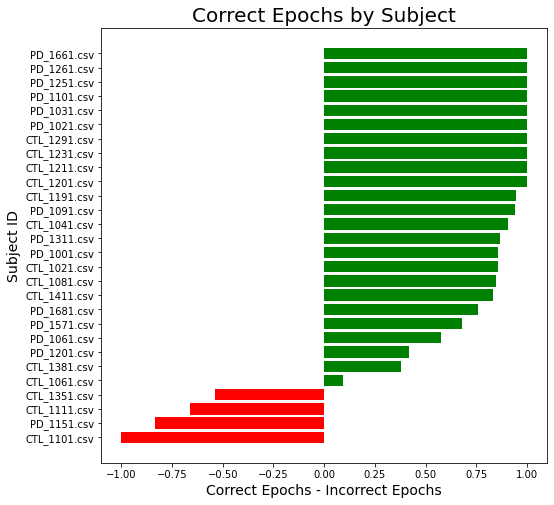

In [19]:
differential = np.array(correct_epochs_list) - np.array(incorrect_epochs_list)
total_epochs = np.array(correct_epochs_list) + np.array(incorrect_epochs_list)
normalized_differential = differential/total_epochs
#print(differential)
diff_list,subject_list = zip(*sorted(zip(normalized_differential, filename_list)))
diff_list = np.array(diff_list)
subject_list = np.array(subject_list)
mask1 = diff_list < 0
mask2 = diff_list >= 0

x = np.arange(len(diff_list))

plt.plot(figsize=(20,12))
plt.barh(x, diff_list, color='red',tick_label=subject_list) #, tick_label=subject_list[mask1]
plt.barh(x[mask2], diff_list[mask2], color='green')
plt.ylabel('Subject ID',size=14);
plt.xlabel('Correct Epochs - Incorrect Epochs', size=14);
plt.title('Correct Epochs by Subject', size=20);
plt.gcf().set_size_inches(8, 8)
plt.show()


high res waterfall plot

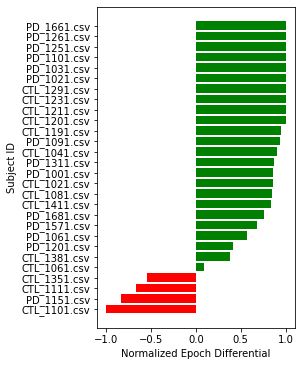

In [20]:
differential = np.array(correct_epochs_list) - np.array(incorrect_epochs_list)
total_epochs = np.array(correct_epochs_list) + np.array(incorrect_epochs_list)
normalized_differential = differential/total_epochs
#proportion = np.array(correct_epochs_list)/(np.array(correct_epochs_list)+np.array(incorrect_epochs_list))
#normalized_differential = proportion
#print(differential)
diff_list,subject_list = zip(*sorted(zip(normalized_differential, filename_list)))
diff_list = np.array(diff_list)
subject_list = np.array(subject_list)
mask1 = diff_list < 0
mask2 = diff_list >= 0

x = np.arange(len(diff_list))

cm = 1/2.54
plt.subplots(1,1, figsize=(9*cm,15*cm))

plt.barh(x, diff_list, color='red',tick_label=subject_list); #, tick_label=subject_list[mask1]
plt.barh(x[mask2], diff_list[mask2], color='green');
plt.ylabel('Subject ID',size=10);
plt.xlabel('Normalized Epoch Differential', size=10);
#plt.title('Correct Epochs by Subject', size=20);
#plt.gcf().set_size_inches(8, 8)
plt.savefig('Figure7_waterfall.jpeg', dpi=300, format='jpeg',bbox_inches='tight');

### Subject-wise ROC Curve

In [21]:
AUC_list = []
subject_AUC_list = []

for i in range(1,10):

  # specify the filename of your pretrained model
  experiment_name = 'UNM_training_replicates_redo_'+str(i)
  #specify the folder location of your model 
  model_folder = '/content/drive/MyDrive/UTOR-MSc/colab_notebooks/model_weights/'
  PATH = model_folder + experiment_name

  if (os.path.exists(PATH)):
    model = torch.load(PATH).to(device)
    print(' model has been successfully loaded')
    
  else:
    print('model was not found')
    chunk_size=2500
    model = PDNet(chunk_size=chunk_size).to(device)
    log_containing_train_loss = []
    log_containing_val_loss = []
    print('new model has been successfully created')

  model.eval()

  sensitivities, specificities = [], []
  subject_sensitvities, subject_specificities = [], []

  for threshold in [0,0.001, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95,0.98,0.999, 1]:
    correct_votes, incorrect_votes, unsure_votes = 0,0,0
    true_positives, false_positives, true_negatives, false_negatives = 0,0,0,0
    subject_TP, subject_FP, subject_TN, subject_FN = 0, 0, 0, 0

    #leave_out will be 
    for filename in filename_list:
      to_test = []
      #print('Performing testing on subject number: ', filename.split('.')[0])

      for index in range(len(EEG_whole_Dataset)):
        
        complete_list = range(len(EEG_whole_Dataset))
        subset_ds = Subset(EEG_whole_Dataset, [index])
        sample_sampler = RandomSampler(subset_ds)
        subset_dataloader = DataLoader(subset_ds, sampler=sample_sampler, batch_size=1)
        data = next(iter(subset_dataloader))
        eeg_data, label, file = data
        
        if file[0] == filename:
          
          to_test.append(index)

      #to_be_kept = [x for x in complete_list if x not in to_be_removed]
      #train_dataset = Subset(EEG_whole_Dataset, to_be_kept)
      
      val_dataset = Subset(EEG_whole_Dataset, to_test)

      
      #train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
      val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
      
      del val_dataset # ,train_dataset


      TP, FP, TN, FN, vote, sequence = validate(model=model, valloader=val_dataloader,threshold=threshold,batch_size=8, supress_output=True)
      true_positives += TP
      false_positives += FP
      true_negatives += TN
      false_negatives += FN

      if vote == 'Correct':
        correct_votes += 1
        if TP >0:
          subject_TP += 1
        elif TN >0:
          subject_TN += 1
        
      elif vote == 'Incorrect':
        incorrect_votes += 1
        if FP >0:
          subject_FP += 1
        elif FN >0:
          subject_FN += 1
      else:
        unsure_votes +=1
    '''
    print('-----------------------------------------------------------------------')
    print('EPOCH LEVEL ANALYSIS')
    print('total True Positives: ', true_positives)
    print('total False Positives: ', false_positives)
    print('total True Negatives: ', true_negatives)
    print('total False Negatives: ', false_negatives)
    '''
    sensitivity = true_positives/(true_positives+false_negatives)
    specificity = true_negatives/(true_negatives+false_positives)
    sensitivities.append(sensitivity)
    specificities.append(specificity)



    print('----------------------------------------------------------------')
    print('SUBJECT LEVEL ANALYSIS')
    '''
    print('total correct subject classifications: ', correct_votes)
    print('total incorrect subject classifications: ', incorrect_votes)
    print('total unsure subject classifications: ',unsure_votes)
    print('total subject level True positives: ', subject_TP)
    print('total subject level False Positives: ', subject_FP)
    print('total subject level True Negatives: ', subject_TN)
    print('total subject level False Negatives: ', subject_FN)
    '''
    subject_accuracy = (subject_TP + subject_TN) / (subject_TP + subject_FP +subject_TN+subject_FN)
    #print('total subject accuracy: ')
    subject_F1 = 2*subject_TP / (2*subject_TP + subject_FP + subject_FN)
    #print('total subject F1: ', subject_F1)
    subject_sensitvity = subject_TP / (subject_TP + subject_FN)
    print('total subject sensitivity: ',subject_sensitvity)
    subject_specificity = subject_TN / (subject_FP + subject_TN)
    print('total subject specificity: ', subject_specificity)
    subject_sensitvities.append(subject_sensitvity)
    subject_specificities.append(subject_specificity)

  AUC = auc((1-np.array(specificities)),sensitivities)
  print('AUC = ', AUC)
  subject_AUC = auc((1-np.array(subject_specificities)),subject_sensitvities)
  print('subject AUC = ',subject_AUC)
  AUC_list.append(AUC)
  subject_AUC_list.append(subject_AUC)

print('AUC list: ', AUC_list)
print('subject AUC list: ', subject_AUC_list)

 model has been successfully loaded
----------------------------------------------------------------
SUBJECT LEVEL ANALYSIS
total subject sensitivity:  1.0
total subject specificity:  0.0
----------------------------------------------------------------
SUBJECT LEVEL ANALYSIS
total subject sensitivity:  1.0
total subject specificity:  0.5384615384615384
----------------------------------------------------------------
SUBJECT LEVEL ANALYSIS
total subject sensitivity:  0.9285714285714286
total subject specificity:  0.7142857142857143
----------------------------------------------------------------
SUBJECT LEVEL ANALYSIS
total subject sensitivity:  0.9285714285714286
total subject specificity:  0.7142857142857143
----------------------------------------------------------------
SUBJECT LEVEL ANALYSIS
total subject sensitivity:  0.9285714285714286
total subject specificity:  0.7857142857142857
----------------------------------------------------------------
SUBJECT LEVEL ANALYSIS
total subje

In [22]:
print(AUC_list)
print(subject_AUC_list)

[0.8328469950187166, 0.7698146019394582, 0.8392025525392756, 0.7556628938603472, 0.817857090223126, 0.8473929318831609, 0.7983575028738173, 0.7918950982992896, 0.7974382497715684]
[0.9095368916797488, 0.8177001569858713, 0.8698979591836734, 0.8775510204081632, 0.8911665257819104, 0.902668759811617, 0.8852040816326531, 0.846938775510204, 0.8941251056635673]


In [23]:
print(np.mean(subject_AUC_list))
print(np.std(subject_AUC_list))

0.8771988085174899
0.027384782241507102


### sequence plot

In [14]:
##################### TESTING ###########################################
'''
Here, a for loop will iterate through every object in the whole dataset. Using the filename, it will determine the
subject number for the sample and make a test set using only the one subject number. It will repeat this for each subject number.
Epochs and Learning rate are adjustable below.
'''
model.eval()
correct_votes, incorrect_votes, unsure_votes = 0,0,0
true_positives, false_positives, true_negatives, false_negatives = 0,0,0,0
subject_TP, subject_FP, subject_TN, subject_FN = 0, 0, 0, 0
correct_epochs_list, incorrect_epochs_list = [], []
list_of_sequences = []


#leave_out will be 
for filename in filename_list:
  
  to_test = []
  print('Performing testing on subject number: ', filename.split('.')[0])

  #make dataset
  single_subject_dataset = EEGDataset(data_path=(data_src+filename),  chunk_size=chunk_size)
  single_subject_dataloader = DataLoader(single_subject_dataset, shuffle=False,  batch_size=1)

  
  TP, FP, TN, FN, vote, seq = validate(model=model, valloader=single_subject_dataloader,threshold=0.5,batch_size=1, supress_output=True)
  list_of_sequences.append(seq)  


Performing testing on subject number:  CTL_1021
there are this many items in the list of data  42
there are this many items in the list of labels  42
The length of the lists of channels means and stds is  60
Performing testing on subject number:  CTL_1041
there are this many items in the list of data  43
there are this many items in the list of labels  43
The length of the lists of channels means and stds is  60
Performing testing on subject number:  CTL_1061
there are this many items in the list of data  42
there are this many items in the list of labels  42
The length of the lists of channels means and stds is  60
Performing testing on subject number:  CTL_1081
there are this many items in the list of data  52
there are this many items in the list of labels  52
The length of the lists of channels means and stds is  60
Performing testing on subject number:  CTL_1101
there are this many items in the list of data  42
there are this many items in the list of labels  42
The length of the 

In [15]:
files = glob.glob(data_src + '*.csv')
subject_list = []
filename_list = []
for file in files:  
  filename = file.split('/')[-1] #remove all preceeding directories
  
  filebasename = filename.split('.')[0] #drop the .csv
  
  subject_number = filebasename[-4:] #last four will be the subject number
  
  subject_list.append(subject_number)
  filename_list.append(filename)
  

In [20]:
import matplotlib as mpl
import seaborn as sns
import matplotlib.patches as mpatches

def make_combo_plot(sequence_list=[], filename_list=[]):
  
  ############################################################
  #create list of normalized correctness and sort it
  diff_list=[]
  sorted_diffs = []
  sorted_sequences = []
  sorted_filenames = []
  sorted_labels = []
  sorted_pvals = []
  for sequence in sequence_list:
    sequence = [i for i in sequence if i != -1]
    correct = sequence.count(1)
    incorrect = sequence.count(0)
    empty = sequence.count(-1)
    diff = (correct-incorrect)/len(sequence)
    diff_list.append(diff)

  zipped = list(zip(diff_list, sequence_list, filename_list))
  zipped.sort()
  sorted_diffs, sorted_sequences, sorted_filenames = map(list, zip(*zipped))

  sorted_diffs = np.flip(np.array(sorted_diffs))
  #percent_list, subject_list = zip(*sorted())
  ################################################################
  #set up a subplot to fill in
  mask1 = sorted_diffs < 0
  mask2 = sorted_diffs >= 0

  x = np.arange(len(sorted_diffs))

  fig, ax = plt.subplots(nrows=1, ncols=4, sharey=True, gridspec_kw={'width_ratios': [1, 1, 0.05, 0.05]})
  plt.plot(figsize=(20,12), ax=ax[0])
  ax[0].barh(x, sorted_diffs, color='#E55451',tick_label=sorted_filenames,align='edge') #, tick_label=subject_list[mask1]
  ax[0].barh(x[mask2], sorted_diffs[mask2], color='#228B22',align='edge')
  ax[0].set_ylabel('Subject ID',size=14);
  ax[0].set_xlabel('Normalized Epoch Accuracy', size=14);
  pop_c = mpatches.Patch(color='#E55451', label='Incorrect Subject')
  pop_d = mpatches.Patch(color='#228B22', label='Correct Subject')
  ax[0].legend(handles=[pop_c,pop_d], bbox_to_anchor=(0.47,1.1))

  ################################################################


  #determine the maximum length of all the sequences
  max_len = 0
  for sequence in sorted_sequences:

    if len(sequence) > max_len:
      max_len = len(sequence)

  #make all lists the same length by appending -1 to the short ones 
  for i, sequence in enumerate(sorted_sequences):

    if len(sequence) < max_len:
      short_by = max_len - len(sequence)

      for j in range(short_by):
        sorted_sequences[i].append(-1)

  sorted_sequences = np.vstack([np.array(i) for i in sorted_sequences])
  flipped_sequences = np.flip(sorted_sequences, axis=0)

  for i, sequence in enumerate(flipped_sequences):
    q, p = statsmodels.sandbox.stats.runs.runstest_1samp(sequence, cutoff='mean', correction=True)
    #print('for subject ', i, ' the p = ', p)
    sorted_pvals.append(p)

  #reshap pvals into two dimensional shape with a singleton dimension
  sorted_pvals = np.asarray(sorted_pvals).reshape(len(sorted_pvals), 1)

  #mask sorted pvals to less than 0.01 and 0.001 
  for i in range(len(sorted_pvals)):
    
      if sorted_pvals[i] < 0.01:
        if sorted_pvals[i]< 0.001:
          sorted_pvals[i] = 2
        else:
          sorted_pvals[i] = 1
      else:
        sorted_pvals[i] = 0


  # define the colors
  cmap = mpl.colors.ListedColormap(['#FFFFFF','#E55451', '#228B22'])

  # create and normalize object the describes the limits of each color
  bounds = [-1, -0.25, 0.5, 1.]
  norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

  # use filenames to deduce the PD or CTLs
  for i in range(len(sorted_filenames)):
    sorted_filenames[i] = sorted_filenames[i].split('.')[0]
    
    if sorted_filenames[i].split('_')[0]== 'CTL':
      sorted_labels.append(0)
    elif sorted_filenames[i].split('_')[0] == 'PD':
      sorted_labels.append(1)
    else:
      assert False, 'error assigning label'
  #reverse the order of the list and make into two dimensional array
  sorted_labels.reverse()
  sorted_labels = np.asarray(sorted_labels).reshape(len(sorted_labels), 1)

  #sequence plot heatmap
  sns.heatmap(flipped_sequences, cmap=cmap, norm=norm, yticklabels=np.flip(sorted_filenames), cbar=False, ax = ax[1]);
  pop_a = mpatches.Patch(color='#E55451', label='Incorrect Epoch')
  pop_b = mpatches.Patch(color='#228B22', label='Correct Epoch')
  ax[1].legend(handles=[pop_a,pop_b], bbox_to_anchor=(0.45,1.1))
  ax[1].set_xlabel('Epoch Number', size=14);
  
  # first colorbar for significance
  # define the colors
  cmap2 = mpl.colors.ListedColormap(['#B9BBB6','#FEE12B','#6F2DB8'])
  pop_non = mpatches.Patch(color='#B9BBB6', label='ns')
  pop_sig = mpatches.Patch(color='#FEE12B', label='*')
  pop_sig2 = mpatches.Patch(color='#6F2DB8', label='**')
  ax[2].legend(handles=[pop_non, pop_sig2], bbox_to_anchor=(0.85,1.1)) #add the pop_sig if there are any examples
  
  # create and normalize object the describes the limits of each color
  bounds = [-1, -0.25, 0.5, 1.]
  norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
  sns.heatmap(sorted_pvals, ax = ax[2], cbar=False, cmap=cmap2)

 

  # define the colors
  cmap3 = mpl.colors.ListedColormap(['#0000FF','#FFA500'])
  pop_ctl = mpatches.Patch(color='#0000FF', label='CTL')
  pop_pd = mpatches.Patch(color='#FFA500', label='PD')
  ax[3].legend(handles=[pop_ctl,pop_pd], bbox_to_anchor=(2.85,1.1))

  # create and normalize object the describes the limits of each color
  bounds = [-1, 0.5, 1.]
  norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
  sns.heatmap(sorted_labels, ax = ax[3], cbar=False, cmap=cmap3)



  
  ax[0].set_yticks(np.arange(len(sorted_filenames)))
  ax[0].set_yticklabels(labels=np.flip(sorted_filenames), va='center')
  plt.gcf().set_size_inches(10, 10)
  plt.savefig('subject_inference_waterfall_combo.png', dpi=300, format='png',bbox_inches='tight')

  


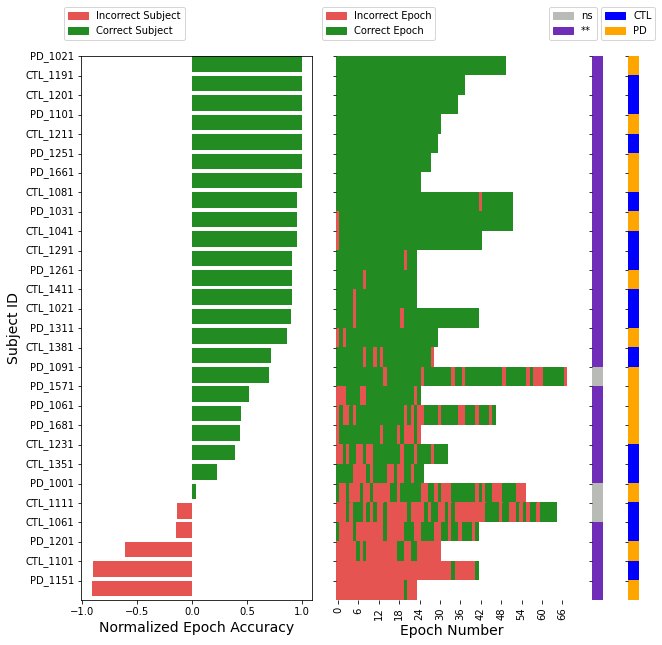

In [21]:
make_combo_plot(list_of_sequences, filename_list)

## Visualization

In [ ]:
def plot_roc_auc(specificities, sensitivities):
  plt.figure(figsize=(6,4))
  plt.plot((1-np.array(specificities)),sensitivities);
  #plt.title('ROC Curve', size= 20);
  plt.xlabel('1-Specificity', size = 14);
  plt.ylabel('Sensitivity', size = 14);
  plt.ylim(0,1)
  plt.legend(['CNN'])
  AUC = auc((1-np.array(specificities)),sensitivities)
  plt.text(0.7,0.2, 'AUC = %f'%AUC, fontsize=10)
  plt.show()


In [ ]:
plot_roc_auc(subject_specificities, subject_sensitvities)

In [ ]:
def plot_roc_matrix(TP, FP, TN, FN, sensitivities, specificities):
  cm = 1/2.54 #define inch to cm
  fig, (ax1, ax2, axcb) = plt.subplots(1,3,gridspec_kw={'width_ratios':[1,1,0.08]}, sharey=False, figsize = (14*cm,4*cm))

  plt.subplots_adjust(wspace=0.45)

  ax1.plot((1-np.array(specificities)),sensitivities);
  ax1.set_xlabel('1-Specificity', size = 7);
  ax1.set_ylabel('Sensitivity', size = 7);
  ax1.legend(['CNN'])
  AUC = auc((1-np.array(specificities)),sensitivities)
  ax1.text(0.5,0.3, 'AUC = %.3f'%AUC, fontsize=7)
  

  pred = []
  true = []

  for i in range(TP):
    pred.append(1)
    true.append(1)
  
  for i in range(FP):
    pred.append(1)
    true.append(0)
  
  for i in range(TN):
    pred.append(0)
    true.append(0)

  for i in range(FN):
    pred.append(0)
    true.append(1)

  
  conf_matrix = (confusion_matrix(true, pred))
  # Using Seaborn heatmap to create the plot
  ax2 = sns.heatmap(conf_matrix,cmap='Blues',vmin=0,vmax=12,ax=ax2,cbar_ax=axcb, annot=True, annot_kws={'fontsize':7},fmt='g')
  
  # labels the title and x, y axis of plot
  #fx.set_title('Insert title here');
  ax2.set_xlabel('Predicted Values',size=7)
  ax2.set_ylabel('Actual Values ', size=7);

  # labels the boxes
  ax2.xaxis.set_ticklabels(['Control','PD'],size=7)
  ax2.yaxis.set_ticklabels(['Control','PD'],size=7)
  #ax2.title.set_text('CV by Subject')
  #fig.tight_layout()
  
  plt.savefig('test_roc_matrix_subject.png', dpi=300, format='png',bbox_inches='tight')

In [ ]:
plot_roc_matrix(TP=12, FP=3, TN=11, FN=2, sensitivities=subject_sensitvities, specificities=subject_specificities)

In [ ]:
plot_roc_matrix(TP=12, FP=3, TN=11, FN=2, sensitivities=[], specificities=[])

In [ ]:
def plot_confusion_matrix(TP, FP, TN, FN):
  cm = 1/2.54 #define inch to cm
  fig, (ax1, axcb) = plt.subplots(1,2,gridspec_kw={'width_ratios':[0.8,0.08]}, sharey=False, figsize = (6*cm,4*cm))
  
  #plt.subplots_adjust(wspace=0.15)
  
  pred = []
  true = []

  for i in range(TP):
    pred.append(1)
    true.append(1)
  
  for i in range(FP):
    pred.append(1)
    true.append(0)
  
  for i in range(TN):
    pred.append(0)
    true.append(0)

  for i in range(FN):
    pred.append(0)
    true.append(1)

  
  conf_matrix = confusion_matrix(true, pred)
  # Using Seaborn heatmap to create the plot
  ax1 = sns.heatmap(conf_matrix,cmap='Blues',vmin=0,vmax=max([TP,FP,TN,FN]),ax=ax1,cbar_ax=axcb, annot=True, annot_kws={'fontsize':7},fmt='g')
  
  # labels the title and x, y axis of plot
  #fx.set_title('Insert title here');
  ax1.set_xlabel('Predicted Values',size=7)
  ax1.set_ylabel('Actual Values ', size=7);

  # labels the boxes
  ax1.xaxis.set_ticklabels(['Control','PD'],size=7)
  ax1.yaxis.set_ticklabels(['Control','PD'],size=7)
  #ax2.title.set_text('CV by Subject')
  #fig.tight_layout()
  
  
  plt.savefig('epochwise_CV_by_subject.png', dpi=300, format='png',bbox_inches='tight')